# Will It Complete? Predicting Starbucks Offer Completion Rates

I elected to build models to predict whether a customer (based on their age, income, age, and how long they've been a member for) would respond to a particular offer. Knowing whether a customer will complete an offer could help us figure out which offer to target to which customers. Potentially, this could drive engagement in a marketing campaign, and over the long run increase customer spending.


During EDA, I found that customers can receive the same offer more than once, and have overlapping offers active at once time. To simplify the situation, I chose to consider whether customers that received an offer would respond to that offer regardless of the number of exposures or exposures to other offers. Thus, I decided to build models for each of the ten offers. For informational offers 3 and 8, I used viewing of the offer as the response; otherwise offer completion was considered the response.

<br><br>

## Preliminaries

In [2]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_recall_fscore_support, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Sometimes use display instead of print
from IPython.display import display

# debugging
from IPython.core.debugger import set_trace

In [3]:
# Read the cleaned data
portfolio = pd.read_csv('./data/portfolio_clean.csv')
profile = pd.read_csv('./data/profile_clean.csv')
transcript = pd.read_csv('./data/transcript_clean.csv')

In [4]:
display(portfolio.head())
display(profile.head())
display(transcript.head())

,offer_id,web,email,mobile,social,offer_type,duration,difficulty,reward
0,1,0,1,1,1,bogo,168,10,10
1,2,1,1,1,1,bogo,120,10,10
2,3,1,1,1,0,informational,96,0,0
3,4,1,1,1,0,bogo,168,5,5
4,5,1,1,0,0,discount,240,20,5


,customer_id,gender,age,income,became_member_on
0,1,NaN,NaN,NaN,2017-02-12
1,2,F,55.0,112000.0,2017-07-15
2,3,NaN,NaN,NaN,2018-07-12
3,4,F,75.0,100000.0,2017-05-09
4,5,NaN,NaN,NaN,2017-08-04


,customer_id,time,event,amount,reward,offer_id
0,4,0,offer_received,NaN,NaN,4.0
1,5,0,offer_received,NaN,NaN,5.0
2,6,0,offer_received,NaN,NaN,10.0
3,7,0,offer_received,NaN,NaN,7.0
4,8,0,offer_received,NaN,NaN,2.0


## Building the model pipelines

This section deals with building both K nearest neighbours (KNN) and random forest classifier (RFC) models for each of the ten offers. I chose to use KNN and RFC as they're fairly simple to implement.


`build_offer_with_demo_action_models` is the main function for model building. It returns dataframes containing each of the ten models for a given classifier type, along with training/test data and offer ids. It uses the following functions in its internal pipeline:
- `get_offer_action_data` is very similar to a function in the EDA notebook. It compiles offer response data (viewing or completion) per customer for each offer.
- `separate_x_y` is an utility function to separate features and targets in the compiled offer data.
- `build_KNN_pipeline_and_fit_CV` and `build_RFC_pipeline_and_fit_CV` run sklearn pipelines to fit the models. I'm using 5-fold cross validation

In [5]:
def build_offer_with_demo_action_models(transcript_df,
                                        profile_df,
                                        portfolio_df,
                                        action_dict={'bogo': 'offer_completed',
                                                     'discount': 'offer_completed',
                                                     'informational': 'offer_viewed'},
                                        model_type='knn',
                                        test_size=0.3,
                                        verbosity=3,
                                        random_state=7):
    """
    Get models for offer viewing/completion.
    
    Input:
    transcript_df - Transaction/event transcript dataframe.
    profile_df    - Customer profiles.
    portfolio_df  - Offer portfolio.
    action_dict   - The action should the model predict for per offer.
    model_type    - Classifier to use. One of 'knn' (k nearest neighbours)
                    or 'rfc' (random forest classifier).
    test_size     - Split size for training/test sets.
    verbosity     - GridSearchCV verbosity level.
    random_state  - random_state to pass down to model building etc.
                  
    
    Returns:
    Dataframe containing columsn:
        offer_id - Offer ids.
        model    - GridSearchCV model for the offer.
        X_train  - Training data features.
        X_test   - Test data features.
        y_train  - Training data targets.
        y_test   - Test data targets.
    """
    output = pd.DataFrame(columns=['offer_id', 'model', 'X_train', 'X_test', 'y_train', 'y_test'])
    
    # Get offer ids and offer types,
    # then generate action type for based on offer type
    # (e.g. informational offers can only be viewed, not completed).
    offer_ids, offer_types = portfolio_df['offer_id'], portfolio_df['offer_type']
    offer_actions = [action_dict[offer_type] for offer_type in offer_types]
    
    for offer_id, action in zip(offer_ids, offer_actions):
        # Get combined customer profile + action completion df
        offer_profile = get_offer_action_data(transcript_df, profile_df, offer_id, action, contain_demo=True)
        # Get X and y 
        X, y = separate_x_y(offer_profile)
        # Split training and test
        X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=test_size,
                                                    random_state=random_state)
        # Switch to build and cross validate a model.
        if model_type == 'knn':
            model = build_KNN_pipeline_and_fit_CV(X_train, y_train, verbosity=verbosity)
        elif model_type == 'rfc':
            model = build_RFC_pipeline_and_fit_CV(X_train, y_train, verbosity=verbosity)
        else:
            raise ValueError(f"Model of type {model_type} not implemented.")
        
        # Append the output
        output = output.append({'offer_id': offer_id,
                                'model': model, 
                                'X_train': X_train,
                                'X_test': X_test,
                                'y_train': y_train,
                                'y_test': y_test
                               }, ignore_index=True)
        
    return output

In [6]:
def get_offer_action_data(transcript_df, profile_df, offer_id, action_type, contain_demo=True):
    """
    For a given offer id, generates a df combining customer profiles with 
    whether they viewed/completed the offer (if they received the offer) over
    the course of the experiment.
    
    Also dummies gender data and converts "became_member_on" to 
    durations of how long a customer has been a customer.
    
    Input:
    transcript_df - Transaction/event transcript dataframe.
    profile_df    - Customer profiles.
    offer_id      - Offer id to process.
    action_type   - 'offer_completed' or 'offer_viewed'.
    contain_demo  - If True, returns only customers having age/gender/income demographic data.
                    If False, returns only customers without demographic data.
    
    Returns:
    offer_profile - Dataframe containing customer profiles and offer view/completion status.
    """
    tr = transcript_df
    pro = profile_df
    
    # Get set of offering completing and non-completing customer ids
    offer_customers = set(tr[(tr.offer_id == offer_id) & (tr.event == 'offer_received')].customer_id)
    offer_completed = set(tr[(tr.offer_id == offer_id) & (tr.event == action_type)].customer_id)
    offer_incomplete = offer_customers - offer_completed
    
    # Appending 0/1 for incomplete/complete to customer profile data
    profile_complete = pro[pro.customer_id.isin(offer_completed)].assign(offer_complete = 1)
    profile_incomplete = pro[pro.customer_id.isin(offer_incomplete)].assign(offer_complete = 0)
    
    offer_profile = pd.concat([profile_complete, profile_incomplete]).sort_values('customer_id')
    
    # Customers w/ demographic data
    if contain_demo == True:
        offer_profile = offer_profile.dropna()
    # Customers missing demographic data
    else:
        offer_profile = offer_profile[offer_profile.isna().any(axis=1)]
        
    # Clean the data
    ## Get dummies for gender
    offer_profile = pd.concat([offer_profile,
                               pd.get_dummies(offer_profile.gender, prefix="gender")],
                              axis=1)
    # Change membership date to duration in years of how long customer
    # has been a customer.
    customer_duration = pd.to_datetime(offer_profile.became_member_on)
    customer_duration = (customer_duration.max() - customer_duration).dt.days/365
    offer_profile['customer_duration'] = customer_duration
    
    # Drop unnecessary columns
    offer_profile = offer_profile.drop(columns=['gender', 'became_member_on', 'customer_id'])
    
    return offer_profile
    

In [7]:
def separate_x_y(df, y_key='offer_complete'):
    """
    Takes a df and separates it into X and y by y_key.
    
    Input:
    df     - A dataframe.
    y_key  - str of the y target column.
    
    Returns:
    X      - Dataframe without y_key column.
    y      - Series from y_key column.
    """
    # Get X and standardize it.
    # i.e. mean = 0, unit variance
    X = df.drop(columns=y_key)    
    y = df[y_key]
    
    return X, y

In [8]:
def build_KNN_pipeline_and_fit_CV(X_train, y_train, verbosity=3, n_neighbors_grid=[1,5,10,20,40,80,160,320,640,1000]):
    """
    Builds a KNN model and fits on training data with cross validation.
    
    Standardizes X data first before feeding into a KNN model.
    
    Input:
    X_train          - Training data features.
    y_train          - Training data targets.
    verbosity        - 0, 1, 2, or 3 to control GridSearchCV output.
    n_neighbors_grid - Search grid for the number of neighbors for the KNN model.
    
    Returns:
    model            - a GridSearchCV model.
    
    """
    pipe = Pipeline([('scaler', StandardScaler()),
                         ('knn', KNeighborsClassifier())])
    
    param_grid = [{'knn__n_neighbors': n_neighbors_grid}]
    model = GridSearchCV(pipe, scoring='f1', param_grid=param_grid, cv=5, refit=True, verbose=verbosity, return_train_score=True)
    
    model.fit(X_train, y_train)
    
    print(f"Best params: {model.best_params_}.")
    print(f"Best score: {round(model.best_score_, 5)}.")
    
    return model

In [9]:
def build_RFC_pipeline_and_fit_CV(X_train,
                                  y_train,
                                  verbosity=3,
                                  param_grid=[{'rfc__n_estimators': [10, 100],
                                               'rfc__max_depth': [100, None],
                                               'rfc__min_samples_split': [2, 5, 10, 20],
                                               'rfc__min_samples_leaf': [1, 2, 4, 8]
                                             }],
                                  random_state=7):
    """
    Builds a random forest classifier and fits on training data with cross validation.
    
    Standardizes X data first before feeding into a RF model.
    
    See https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    for hyperparameter tuning example.
    
    Input:
    X_train          - Training data features.
    y_train          - Training data targets.
    verbosity        - 0, 1, 2, or 3 to control GridSearchCV output.
    param_grid       - Search grid for the RF model. Prefix params with 'rfc__'.
    random_state     - random int for the RF model.
    
    Returns:
    model            - a GridSearchCV model.
    """
    pipe = Pipeline([('scaler', StandardScaler()),
                         ('rfc', RandomForestClassifier())])
    
 
    
    model = GridSearchCV(pipe, scoring='f1', param_grid=param_grid, cv=5, refit=True, verbose=verbosity, return_train_score=True)
    
    model.fit(X_train, y_train)
    
    print(f"Best params: {model.best_params_}.")
    print(f"Best score: {round(model.best_score_, 5)}.")
    
    return model

In [18]:
knn_models = build_offer_with_demo_action_models(transcript, profile, portfolio, model_type='knn', verbosity=1, random_state=7)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'knn__n_neighbors': 160}.
Best score: 0.75268.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'knn__n_neighbors': 160}.
Best score: 0.71826.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'knn__n_neighbors': 160}.
Best score: 0.70603.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'knn__n_neighbors': 1000}.
Best score: 0.7945.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'knn__n_neighbors': 320}.
Best score: 0.7185.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'knn__n_neighbors': 320}.
Best score: 0.86337.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'knn__n_neighbors': 320}.
Best score: 0.87384.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'knn__n_neighbors': 20}.
Best score: 0.94924.
Fitting 5 folds for each o

In [19]:
rfc_models = build_offer_with_demo_action_models(transcript, profile, portfolio, model_type='rfc', verbosity=1, random_state=7)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best params: {'rfc__max_depth': None, 'rfc__min_samples_leaf': 8, 'rfc__min_samples_split': 5, 'rfc__n_estimators': 10}.
Best score: 0.75766.
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best params: {'rfc__max_depth': 100, 'rfc__min_samples_leaf': 8, 'rfc__min_samples_split': 5, 'rfc__n_estimators': 100}.
Best score: 0.71953.
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best params: {'rfc__max_depth': 100, 'rfc__min_samples_leaf': 8, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 100}.
Best score: 0.68757.
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best params: {'rfc__max_depth': 100, 'rfc__min_samples_leaf': 8, 'rfc__min_samples_split': 10, 'rfc__n_estimators': 100}.
Best score: 0.78956.
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best params: {'rfc__max_depth': None, 'rfc__min_samples_leaf': 8, 'rfc__min_samples_split': 10, 'rfc__n_estimators': 100}

In [35]:
# Save the models
pickle.dump(knn_models, open("models/knn.model", "wb"))
pickle.dump(rfc_models, open("models/rfc.model", "wb"))

## Model prediction

`multiple_predict_score` uses the test data saved with the "model" objects in order to generate predictions using the models. These predictions are then scored using F1 (which I chose for a good balance of precision and recall).

In [10]:
# Load the models
knn_models = pickle.load(open("models/knn.model", "rb"))
rfc_models = pickle.load(open("models/rfc.model", "rb"))

In [11]:
def multiple_predict_score(offer_ids, models, test_features, test_targets):
    """
    Predict using multiple models for multiple dataframes of features.
    
    That is, models are paired with one dataframe of features. 
    
    Input:
    offer_ids     - Series of offer ids.
    models        - Series of GridSearchCV models.
    test_features - Series of X features dataframes.
    test_targets  - Series of y targets corresponding to X.
    
    Returns:
    
    Dataframe of offer_ids and predictions.
    """
    # Use each model to predict on one set of X
    y_preds = []
    for model, X in zip(models, test_features):
        y_preds.append(pd.Series(model.predict(X)))
    
    y_preds = pd.Series(y_preds, name='y_preds')
    
    # Score 
    scores = []
    for preds, targets in zip(y_preds, test_targets):
        scores.append(f1_score(targets, preds))

    scores = pd.Series(scores, name='scores')
    return pd.concat([offer_ids,
                      y_preds,
                      scores],
                     axis=1)

In [12]:
# Get predictions and f1 scores for knn models on test and training set
knn_train = multiple_predict_score(knn_models.offer_id, knn_models.model, knn_models.X_train, knn_models.y_train)
knn_test = multiple_predict_score(knn_models.offer_id, knn_models.model, knn_models.X_test, knn_models.y_test)

In [13]:
# Double check that test set for rfc and knn are the same.
# (They came from the same random state split)
for e, f in zip(rfc_models.X_test, knn_models.X_test):
    assert e.equals(f)

In [14]:
# Get predictions and f1 scores for knn models on test and training set
# Note as above, rfc test set is same as knn test set.
rfc_train = multiple_predict_score(rfc_models.offer_id, rfc_models.model, rfc_models.X_train, rfc_models.y_train)
rfc_test = multiple_predict_score(rfc_models.offer_id, rfc_models.model, rfc_models.X_test, rfc_models.y_test)

In [15]:
# Generate scores for plotting
scores_df = pd.DataFrame({'offer_id': knn_train.offer_id, 
                          'knn_train': knn_train.scores,
                          'knn_test': knn_test.scores,
                          'rfc_train': rfc_train.scores,
                          'rfc_test': rfc_test.scores})

In [16]:
scores_df

,offer_id,knn_train,knn_test,rfc_train,rfc_test
0,1,0.759182,0.757758,0.814649,0.759674
1,2,0.723587,0.735505,0.795078,0.732743
2,3,0.707185,0.697026,0.786507,0.691675
3,4,0.794410,0.793331,0.842105,0.779949
4,5,0.721158,0.715481,0.795210,0.729450
5,6,0.863250,0.859866,0.899872,0.854283
6,7,0.874379,0.852482,0.912127,0.859046
7,8,0.949245,0.950903,0.950150,0.950903
8,9,0.788842,0.805088,0.844615,0.794849
9,10,0.777585,0.775256,0.819051,0.764734


<br><br>

Below is a plot of training vs test scores fpr the two types of classifiers for each offer.

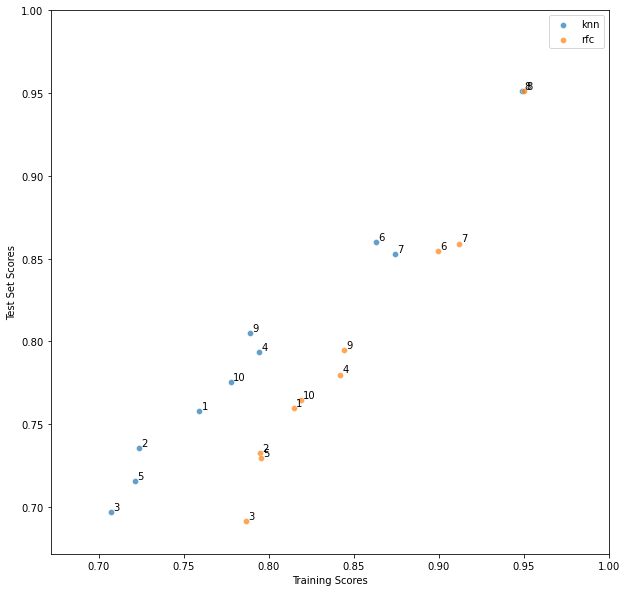

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(ax=ax, data=scores_df, x='knn_train', y='knn_test', label='knn', alpha=0.7)
sns.scatterplot(ax=ax, data=scores_df, x='rfc_train', y='rfc_test', label='rfc', alpha=0.7)

offset = 0.0013
for x, y, s in zip(scores_df.knn_train, scores_df.knn_test, scores_df.offer_id):
    plt.text(x + offset, y + offset, s)
    
for x, y, s in zip(scores_df.rfc_train, scores_df.rfc_test, scores_df.offer_id):
    plt.text(x + offset, y + offset, s)

# Set axis minimum to be lowest score - offset
lim_min = scores_df.drop(columns='offer_id').min().min() - 0.02
plt.xlabel("Training Scores")
plt.ylabel("Test Set Scores")
plt.xlim(lim_min, 1)
plt.ylim(lim_min, 1);


In [19]:
portfolio

,offer_id,web,email,mobile,social,offer_type,duration,difficulty,reward
0,1,0,1,1,1,bogo,168,10,10
1,2,1,1,1,1,bogo,120,10,10
2,3,1,1,1,0,informational,96,0,0
3,4,1,1,1,0,bogo,168,5,5
4,5,1,1,0,0,discount,240,20,5
5,6,1,1,1,1,discount,168,7,3
6,7,1,1,1,1,discount,240,10,2
7,8,0,1,1,1,informational,72,0,0
8,9,1,1,1,1,bogo,120,5,5
9,10,1,1,1,0,discount,168,10,2


<br><br>

Some test scores are very high. However, plotting against the proportion of response (i.e. the response rates) shows that the high scores are mostly due to class imbalance.

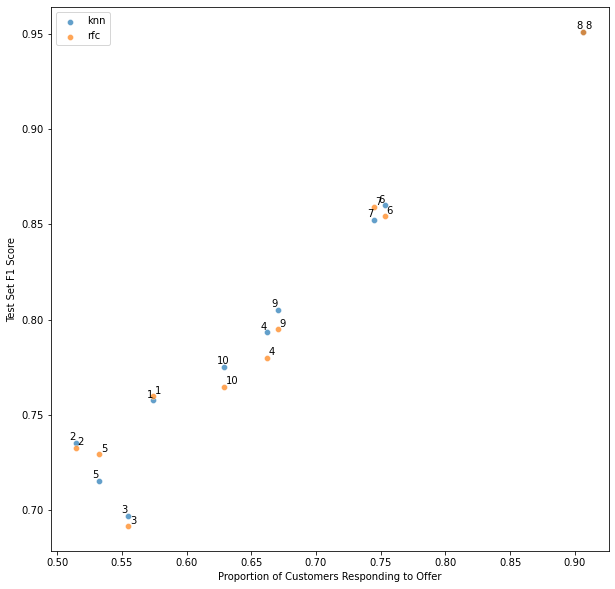

In [35]:
def prep_f1_vs_proportion_data(models, test_outcomes):
    """
    Prepares a dataframe for plotting F1 scores vs. actual customer response proportions.
    
    Useful for analyzing if class imbalances are causing high F1 scores.
    
    Input:
    models        - output from `build_offer_with_demo_action_models()`
    test_outcomes - output from `multiple_predict_score()` on test data
    
    Returns:
        A dataframe with f1 scores and actual customer response proportions (i.e. y_true's).
    """
    data = []
    for offer_id, true, pred in zip(models['offer_id'], models['y_test'], test_outcomes['y_preds']):
        data.append({'true_proportion_responded': true.mean(), 'f1': f1_score(true, pred), 'offer_id': offer_id})

    return pd.DataFrame(data)

k = knn_f1_v_prop = prep_f1_vs_proportion_data(knn_models, knn_test)
r = rfc_f1_v_prop = prep_f1_vs_proportion_data(rfc_models, rfc_test)

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(ax=ax, data=k, x='true_proportion_responded', y='f1', label='knn', legend=True, alpha=0.7)
sns.scatterplot(ax=ax, data=r, x='true_proportion_responded', y='f1', label='rfc', legend=True, alpha=0.7)


# Plot offer id text
offset = 0.0013
for x, y, s in zip(k.true_proportion_responded, k.f1, k.offer_id):
    plt.text(x - 4*offset, y + offset, s)
    
for x, y, s in zip(r.true_proportion_responded, r.f1, r.offer_id):
    plt.text(x + offset, y + offset, s)


ax.set_xlabel('Proportion of Customers Responding to Offer')
ax.set_ylabel('Test Set F1 Score');

## References

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74